In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

from typing import List, Dict
from gretel_client import configure_session

In [3]:
# Specify your Gretel API key

pd.set_option("max_colwidth", None)

configure_session(api_key='grtu9cd34f3901cfac9e13f08002d42705fcbb214dca7a7731179c6a318cb2af2e0a', cache="yes", validate=True)


Using endpoint https://api.gretel.cloud
Logged in as hoang.nd@orai.io ✅


In [4]:
# Load timeseries example to a dataframe

data_source = "./AAPL Historical Data.csv"
original_df = pd.read_csv(data_source)
original_df.to_csv("original.csv", index=False)
original_df


,Date,Price
0,11/01/2013,19.86
1,12/01/2013,20.04
2,01/01/2014,17.88
3,02/01/2014,18.79
4,03/01/2014,19.17
...,...,...
94,09/01/2021,141.50
95,10/01/2021,149.80
96,11/01/2021,165.30
97,12/01/2021,177.57


In [5]:
# Gretel Transforms Configuration
config = """
schema_version: "1.0"
models:
    - transforms:
        data_source: "__tmp__"
        policies:
            - name: shiftnumbers
              rules:
                - name: shiftnumbers
                  conditions:
                    field_name:
                        - Price
                  transforms:
                    - type: numbershift
                      attrs:
                        min: 1
                        max: 100
                        field_name:
                            - Date
              
"""


In [6]:
# De-identify the original dataset using the policy above
import yaml

from gretel_client.projects import create_or_get_unique_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_or_get_unique_project(name="numbershift-transform")

model = project.create_model_obj(
    model_config=yaml.safe_load(config), data_source=data_source
)

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

record_handler = model.create_record_handler_obj(data_source=data_source)
record_handler.submit_cloud()
poll(record_handler)

deid_df = pd.read_csv(record_handler.get_artifact_link("data"), compression="gzip")


INFO: Starting poller


{
    "uid": "633ffe9938fdbfad39527810",
    "guid": "model_2FnqjNYK4dOKuQbBFKSszD43hOK",
    "model_name": "clumsy-fabulous-weasel",
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633ffe8e44a4f15b630a3527",
    "project_guid": "proj_2FnqhzkG3XtUbB0nSxJQHK6Y0fU",
    "status_history": {
        "created": "2022-10-07T10:25:29.754017Z"
    },
    "last_modified": "2022-10-07T10:25:29.953364Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:c9b59a72bc0f0d73111d7bc7e52a9c5b8cb6eb44734caa23dc02b1672fa7fc51",
    "container_image_version": "2.10.0",
    "model_type": "transform",
    "config": {
        "schema_vers

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-10-07T10:25:45.278939Z  Starting transforms model training
2022-10-07T10:25:45.279629Z  Loading training data
2022-10-07T10:25:45.553325Z  Using up to 10000 records for training
2022-10-07T10:25:45.553737Z  Training data loaded
2022-10-07T10:25:45.554084Z  Beginning transforms model training
2022-10-07T10:25:48.560386Z  Saving model archive
2022-10-07T10:25:48.562234Z  Saving training report
2022-10-07T10:25:48.563548Z  Generating data preview with up to 100 records
2022-10-07T10:25:48.592237Z  Done generating data preview
2022-10-07T10:25:48.592843Z  Uploading artifacts to Gretel Cloud
2022-10-07T10:25:49.274221Z  Model creation complete!
INFO: Starting poller


{
    "uid": "633ffeb4945178bc06f94502",
    "guid": "model_run_2FnqmkPQpKAmfvQAiarnCRpF4AV",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "633ff67bbff621779f449273",
    "user_guid": "user_2FnmWFhqEDJhOMwCmsPcFDdNX3q",
    "billing_domain": null,
    "billing_domain_guid": null,
    "project_id": "633ffe8e44a4f15b630a3527",
    "project_guid": "proj_2FnqhzkG3XtUbB0nSxJQHK6Y0fU",
    "status_history": {
        "created": "2022-10-07T10:25:56.042000Z"
    },
    "last_modified": "2022-10-07T10:25:56.150000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:c9b59a72bc0f0d73111d7bc7e52a9c5b8cb6eb44734caa23dc02b1672fa7fc51",
    "container_image_version": "2.10.0",
    "model_id": "633ffe9938fdbfad39527810",
    "model_guid": "model_2FnqjNYK4dOKuQ

INFO: Status is created. A Record transform job has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin transforming records.
INFO: Status is active. A worker has started!
2022-10-07T10:26:08.024820Z  Downloading model to worker
2022-10-07T10:26:08.705696Z  Loading model
2022-10-07T10:26:08.761630Z  Loading dataset to transform
2022-10-07T10:26:09.109046Z  Starting transform
2022-10-07T10:26:09.133089Z  Transform in progress
{
    "records_transformed": 99,
    "new_records_transformed": 99
}
2022-10-07T10:26:09.133610Z  Dataset transform complete
2022-10-07T10:26:09.141062Z  Uploading data to Gretel Cloud
2022-10-07T10:26:09.384956Z  Uploading run report to Gretel Cloud


In [155]:
# View the transformation report

import json
from smart_open import open

report = json.loads(open(model.get_artifact_link("report_json")).read())
pd.DataFrame(report["metadata"]["fields"])


,name,count,approx_distinct_count,missing_count,labels,attributes,entities,types
0,net_amt,5544,5453,0,[],[],[],"[{'type': 'number', 'count': 5544}]"
1,date,5544,72,0,[datetime],[],"[{'label': 'datetime', 'count': 5544, 'approx_distinct_count': 72, 'f_ratio': 1.0, 'sources': ['gretel/datetime']}]","[{'type': 'string', 'count': 5544}]"
2,account_balance,5544,5465,0,[],[],[],"[{'type': 'number', 'count': 5544}]"
3,credit_amt,5544,5466,0,[],[],[],"[{'type': 'number', 'count': 5544}]"
4,district_id,5544,77,0,[],[],"[{'label': 'location', 'count': 4896, 'approx_distinct_count': 68, 'f_ratio': 0.8831168831168831, 'sources': ['gretel/location']}]","[{'type': 'number', 'count': 5544}]"
5,debit_amt,5544,5319,0,[],[],[],"[{'type': 'number', 'count': 5544}]"


In [156]:
# Here we sort and remove "net_amt" as it's a derived column,
# We will add back in after the data is synthesized
train_df = deid_df.copy()

train_df.sort_values("date", inplace=True)
train_cols = list(train_df.columns)
train_cols.remove("net_amt")
train_df = train_df.filter(train_cols)

# Here we noticed that some number have extremely long precision,
# so we round the data
train_df = train_df.round(1)
train_df.to_csv("train.csv", index=False)
train_df


,date,account_balance,credit_amt,district_id,debit_amt
1814,1993-01-31,1132.0,1132.0,52,32.0
5392,1993-01-31,91.0,91.0,2,91.0
3888,1993-01-31,264.0,264.0,23,64.0
1509,1993-01-31,30.0,30.0,56,30.0
1106,1993-01-31,6010.5,6010.5,62,66.0
...,...,...,...,...,...
5086,1998-12-31,2044862.7,827593.8,3,692353.7
169,1998-12-31,5873315.7,3070591.4,74,2491755.5
3228,1998-12-31,1599165.1,525864.4,30,462125.0
4743,1998-12-31,2266274.9,1086885.0,9,1010709.2


In [164]:
from gretel_client.projects.models import read_model_config

# Create a project and model configuration.
project = create_or_get_unique_project(name="ts-5544-regular-seed")

# Pull down the default synthetic config.  We will modify it slightly.
config = read_model_config("synthetics/default")

# Set up the seed fields
seed_fields = ["date", "district_id"]

task = {
    "type": "seed",
    "attrs": {
        "fields": seed_fields,
    },
}

# Fine tune model parameters. These are the parameters we found to work best.  This is "Run 20" in the document
config["models"][0]["synthetics"]["task"] = task

config["models"][0]["synthetics"]["params"]["vocab_size"] = 20
config["models"][0]["synthetics"]["params"]["learning_rate"] = 0.005
config["models"][0]["synthetics"]["params"]["epochs"] = 100
config["models"][0]["synthetics"]["params"]["gen_temp"] = 0.8
config["models"][0]["synthetics"]["params"]["reset_states"] = True
config["models"][0]["synthetics"]["params"]["dropout_rate"] = 0.5
config["models"][0]["synthetics"]["params"]["gen_temp"] = 0.8
config["models"][0]["synthetics"]["params"]["early_stopping"] = True
config["models"][0]["synthetics"]["privacy_filters"]["similarity"] = None
config["models"][0]["synthetics"]["privacy_filters"]["outliers"] = None
config["models"][0]["synthetics"]["generate"]["num_records"] = train_df.shape[0]

# Get a csv to work with, just dump out the train_df.
deid_df.to_csv("train.csv", index=False)

# Initiate a new model with the chosen config
model = project.create_model_obj(model_config=config, data_source="train.csv")

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

synthetic = pd.read_csv(model.get_artifact_link("data_preview"), compression="gzip")
synthetic


In [158]:
# Add back in the derived column "net_amt"
net_amt = synthetic["credit_amt"] - synthetic["debit_amt"]
synthetic["net_amt"] = net_amt

# Save off the new synthetic data
synthetic.to_csv("synthetic.csv", index=False, header=True)


<Figure size 640x480 with 0 Axes>

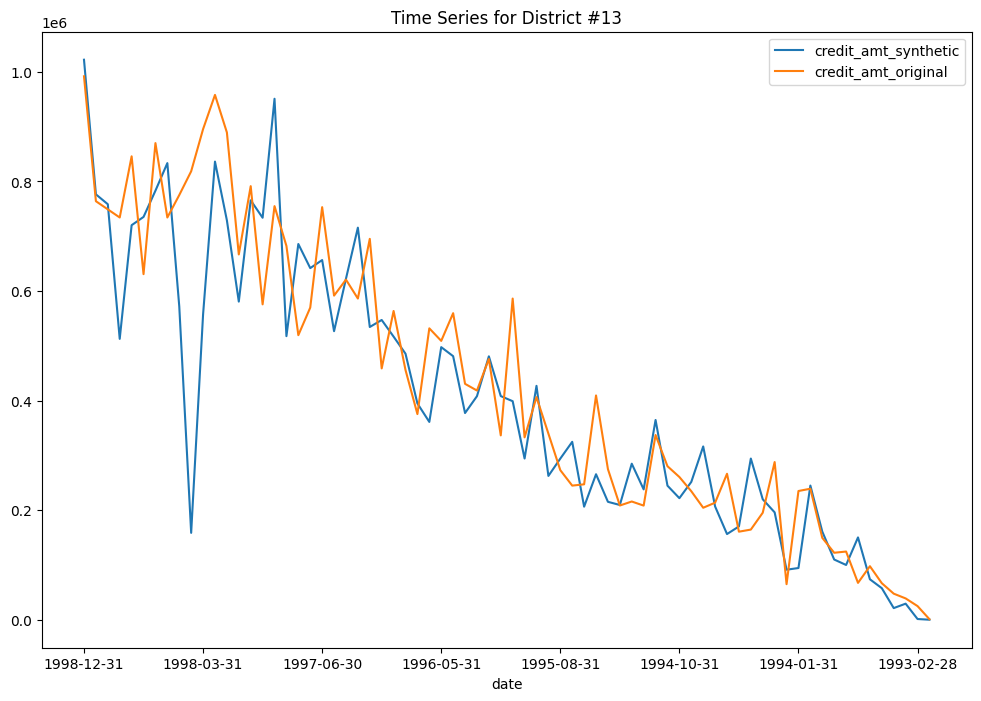

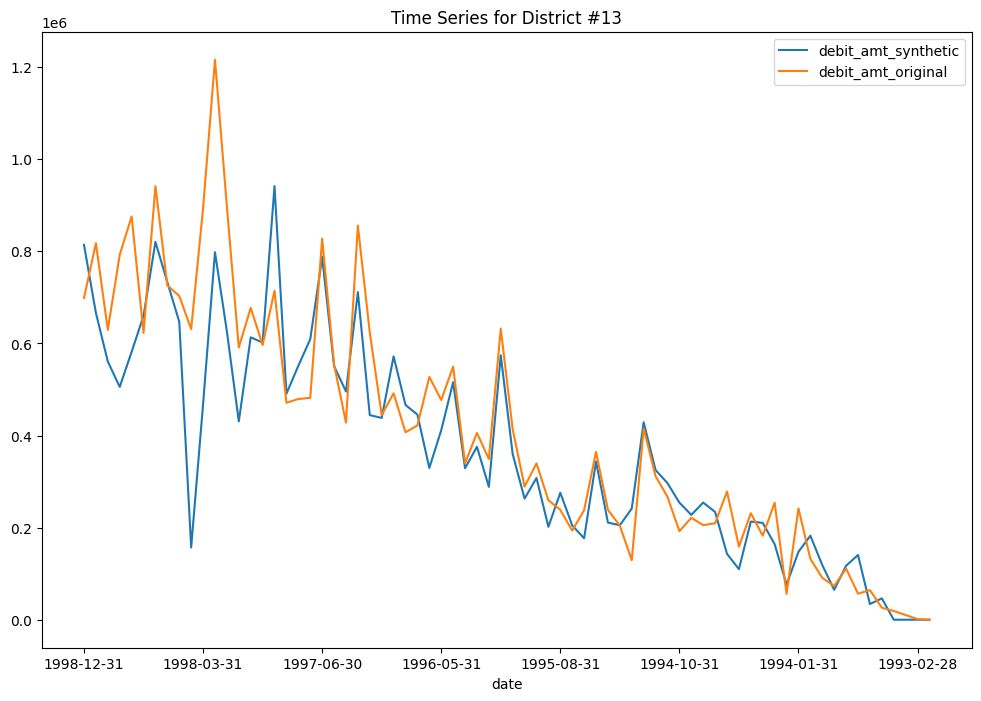

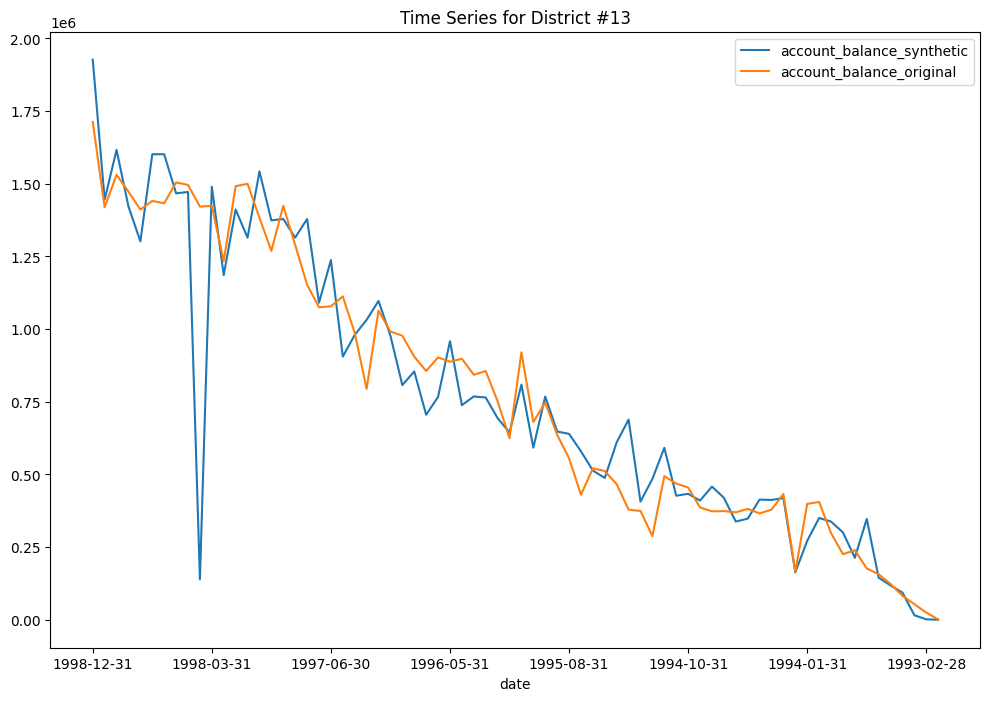

In [160]:
import matplotlib
import matplotlib.pyplot as plt


def plot_district_averages(
    synthetic: pd.DataFrame, training: pd.DataFrame, district_id: int
) -> pd.DataFrame:

    synthetic_data = synthetic.loc[synthetic["district_id"] == district_id]
    synthetic_data = synthetic_data.set_index("date")

    training_data = training.loc[training["district_id"] == district_id]
    training_data = training_data.set_index("date")

    combined = synthetic_data.join(
        training_data, lsuffix="_synthetic", rsuffix="_original"
    )
    plt.suptitle("District #" + str(district_id))

    for col in ["credit_amt", "debit_amt", "account_balance"]:
        fig = combined.plot(y=[f"{col}_synthetic", f"{col}_original"], figsize=(12, 8))
        plt.title("Time Series for District #" + str(district_id))

    return combined


combined = plot_district_averages(synthetic, train_df, 13)
